# Predictive Protein Type Classification

## Background

Proteins can be grouped into categories based on functionality. Examples include ribosomal proteins which are involved in mRNA translation, and various types of enzymes like hydrolase, oxireductase, transferase, etc., each of which catalyzes a specific type of reaction. These proteins are often similar in structure by virtue of their similarity in function, which implies that a study of structural features might offer some indicators about the function of the protein.

## Goal
This project has several goals. First and foremost, it is an exercise in training and applying various machine learning methods to an arbitrary data set. Second, it is a proof-of-concept which demonstrates that machine learning can be used to help make reasonable predictions about the class of a protein based on a superficial set of features. 

## Data Description
The data set being used contains the following features:
* **classification** - the assigned class of the protein (i.e. what we are trying to predict)
* **structureMolecularWeight** - the total molecular weight of the protein
* **crystallizationTempK** - temperature at which the protein crystallizes (in Kelvin)
* **densityMatthews** - Matthews Density coefficient (a coefficient that relates the volume of a protein crystal to the molecular weight)
* **densityPercentSol** - density percent solution (density expressed as a ratio of solid to liquid in the crystallized protein)
* **phValue** - overall pH of the protein

## Process
We will first explore and clean the data. Then, we will apply several ML algorithms to this problem, including Logistic Regression, K-Nearest Neighbors (KNN), Random Forest Classifier, and Decision Tree Classifier, attempt to optimize each, and compare the resulting performance of the models in terms of accuracy.

### Package Imports

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from time import process_time

### Load the Data Set

In [215]:
# https://www.kaggle.com/datasets/shahir/protein-data-set

mol_class_df = pd.read_csv('/Users/stefan/Downloads/data/protein_class/pdb_data_no_dups.csv')
mol_class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141401 entries, 0 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               141401 non-null  object 
 1   classification            141399 non-null  object 
 2   experimentalTechnique     141401 non-null  object 
 3   macromoleculeType         137636 non-null  object 
 4   residueCount              141401 non-null  int64  
 5   resolution                128589 non-null  float64
 6   structureMolecularWeight  141401 non-null  float64
 7   crystallizationMethod     96242 non-null   object 
 8   crystallizationTempK      97039 non-null   float64
 9   densityMatthews           124724 non-null  float64
 10  densityPercentSol         124749 non-null  float64
 11  pdbxDetails               118534 non-null  object 
 12  phValue                   105110 non-null  float64
 13  publicationYear           117602 non-null  f

In [217]:
# add sequence data
seq_data_df = pd.read_csv('/Users/stefan/Downloads/data/protein_class/pdb_data_seq.csv')
seq_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           467276 non-null  object
 3   residueCount       467304 non-null  int64 
 4   macromoleculeType  432487 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.8+ MB


In [219]:
# merge protein and sequence data sets
mol_class_df = mol_class_df.set_index('structureId')
raw_df = mol_class_df.merge(seq_data_df, on='structureId', how='left')
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471811 entries, 0 to 471810
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               471811 non-null  object 
 1   classification            471807 non-null  object 
 2   experimentalTechnique     471811 non-null  object 
 3   macromoleculeType_x       435379 non-null  object 
 4   residueCount_x            471811 non-null  int64  
 5   resolution                449845 non-null  float64
 6   structureMolecularWeight  471811 non-null  float64
 7   crystallizationMethod     314863 non-null  object 
 8   crystallizationTempK      317806 non-null  float64
 9   densityMatthews           390156 non-null  float64
 10  densityPercentSol         390278 non-null  float64
 11  pdbxDetails               385664 non-null  object 
 12  phValue                   340901 non-null  float64
 13  publicationYear           414031 non-null  f

### Exploration and Cleaning of the Data

In [222]:
# we only want proteins, so drop other types
raw_df2 = raw_df[ (raw_df['macromoleculeType_x'].str.contains('Protein')) | (raw_df['macromoleculeType_y'].str.contains('Protein')) ]
print(raw_df2['macromoleculeType_x'].unique())

['Protein' 'Protein#DNA' 'Protein#RNA' 'Protein#DNA/RNA Hybrid'
 'Protein#DNA#RNA' 'Protein#DNA#DNA/RNA Hybrid'
 'Protein#RNA#DNA/RNA Hybrid']


#### Protein Classifications

In [225]:
# explore the protein classifications

print(raw_df2['classification'].nunique()) # 4906 - too many categories
#print(raw_df2['classification'].unique())
print(raw_df2['classification'].value_counts())

4906
classification
HYDROLASE                                 46842
RIBOSOME                                  41172
TRANSFERASE                               36820
OXIDOREDUCTASE                            34358
IMMUNE SYSTEM                             15734
                                          ...  
RNA BINDING PROTEIN/STRUCTURAL PROTEIN        1
XYLANASE A                                    1
GLUTATHIONE REDUCTASE                         1
CELL ADHESION, CELL CYCLE                     1
antimicrobial                                 1
Name: count, Length: 4906, dtype: int64


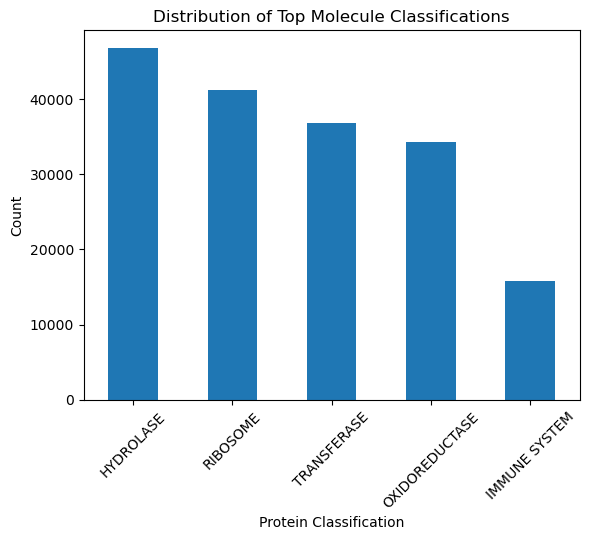

In [227]:
# looks like there are quite few classes that do not have
# enough representation in the data to be useful for training
# we will focus on the classes with the highest representation (>15k samples)

class_counts = raw_df2['classification'].value_counts()
top_classes = class_counts[ (class_counts > 15000) ].index
raw_df3 = raw_df2[ raw_df2['classification'].isin(list(top_classes)) ]

#print(raw_df3['classification'].nunique()) # 5
#print(raw_df3['classification'].unique())
#print(raw_df3['classification'].value_counts())
#raw_df3.info()

# plot the protein classifications represented in our data
plt.figure()
plt.title('Distribution of Top Molecule Classifications')
raw_df3['classification'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Protein Classification")
plt.show()

In [229]:
# clean the data

# residueCount - this comes from both sets, so make sure they agree
#print(len(raw_df3[ raw_df3['residueCount_x'] != raw_df3['residueCount_y'] ])) # 0
raw_df3 = raw_df3.rename({'residueCount_x': 'residueCount'}, axis=1)

# drop columns we don't need and NA
mol_class_df_cleaned = raw_df3.drop([
    'structureId',
    'experimentalTechnique',
    'macromoleculeType_x',
    'resolution',
    'crystallizationMethod',
    'pdbxDetails',
    'publicationYear',
    'chainId',
    'sequence',
    'residueCount_y',
    'macromoleculeType_y'
], axis=1).dropna()

print(mol_class_df_cleaned.info())
print(mol_class_df_cleaned.shape) # 83959 rows, 8 columns

<class 'pandas.core.frame.DataFrame'>
Index: 108136 entries, 769 to 471173
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   classification            108136 non-null  object 
 1   residueCount              108136 non-null  int64  
 2   structureMolecularWeight  108136 non-null  float64
 3   crystallizationTempK      108136 non-null  float64
 4   densityMatthews           108136 non-null  float64
 5   densityPercentSol         108136 non-null  float64
 6   phValue                   108136 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.6+ MB
None
(108136, 7)


#### Residue Count

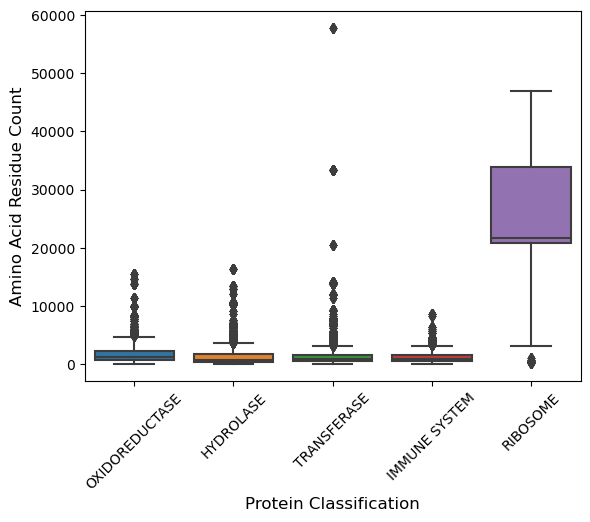

In [232]:
# residueCount

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="residueCount")
plt.ylabel("Amino Acid Residue Count", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()
# ribosomal proteins are considerably larger on average than the others!

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


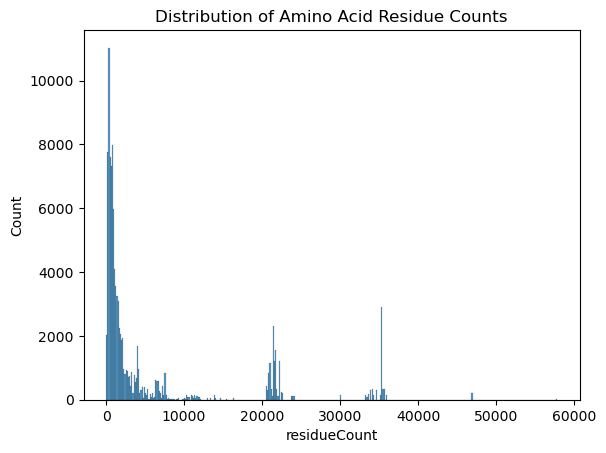

In [234]:
# distribution of residueCount

plt.figure()
sns.histplot(mol_class_df_cleaned['residueCount'])
plt.title('Distribution of Amino Acid Residue Counts')
plt.xlabel('residueCount')
plt.ylabel('Count')
plt.show()

#### Molecular Weight

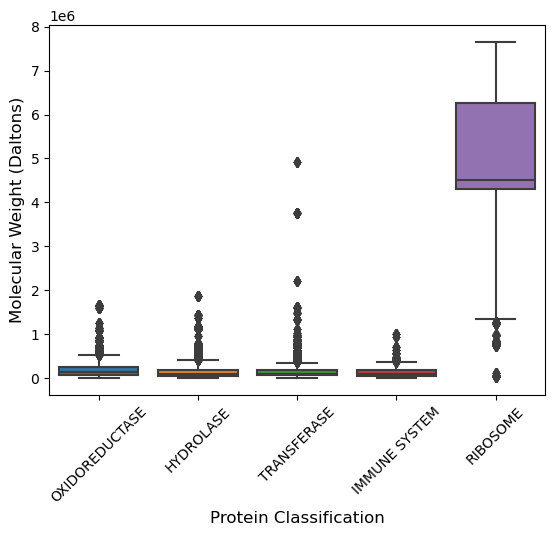

In [237]:
# structureMolecularWeight

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="structureMolecularWeight")
plt.ylabel("Molecular Weight (Daltons)", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


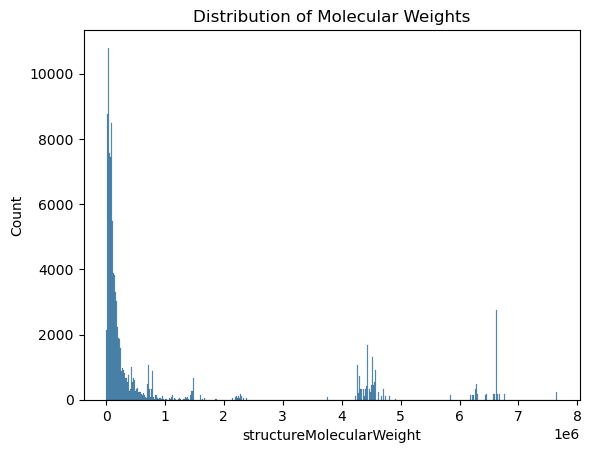

In [239]:
# distribution of structureMolecularWeights

plt.figure()
sns.histplot(mol_class_df_cleaned['structureMolecularWeight'])
plt.title('Distribution of Molecular Weights')
plt.xlabel('structureMolecularWeight')
plt.ylabel('Count')
plt.show()

#### Crystallization Temperature

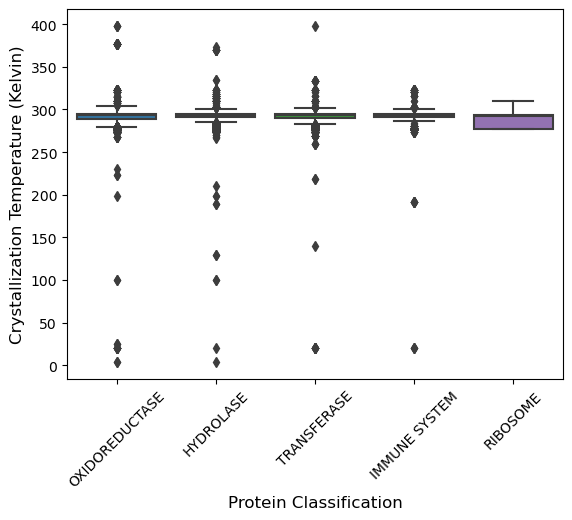

In [242]:
# crystallizationTempK

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="crystallizationTempK")
plt.ylabel("Crystallization Temperature (Kelvin)", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


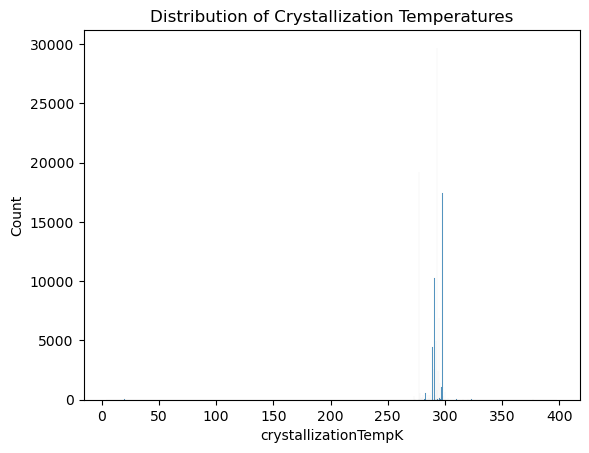

In [244]:
# distribution of crystallizationTempK

#print(mol_class_df_cleaned['crystallizationTempK'].min()) # 4 Kelvin? really?
#print(mol_class_df_cleaned['crystallizationTempK'].max()) # 398 Kelvin

plt.figure()
sns.histplot(mol_class_df_cleaned['crystallizationTempK'])
plt.title('Distribution of Crystallization Temperatures')
plt.xlabel('crystallizationTempK')
plt.ylabel('Count')
plt.show()

#### Matthews Density

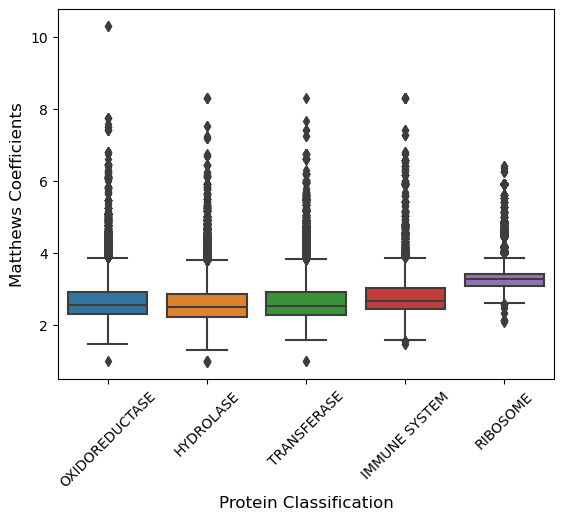

In [247]:
# densityMatthews

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="densityMatthews")
plt.ylabel("Matthews Coefficients", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


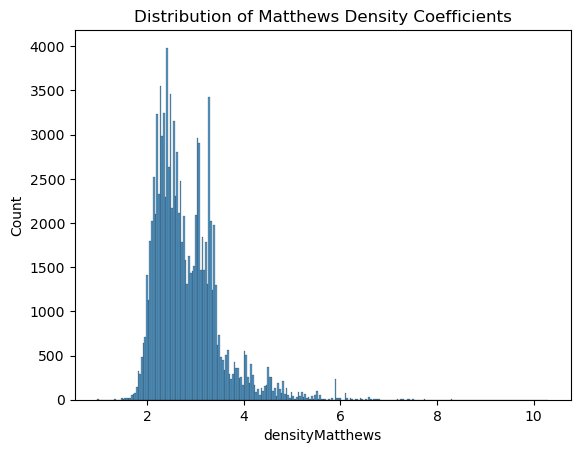

In [249]:
# distribution of densityMatthews coefficients

plt.figure()
sns.histplot(mol_class_df_cleaned['densityMatthews'])
plt.title('Distribution of Matthews Density Coefficients')
plt.xlabel('densityMatthews')
plt.ylabel('Count')
plt.show()

#### Density Percent Solution

density expressed as a ratio liquid to solid

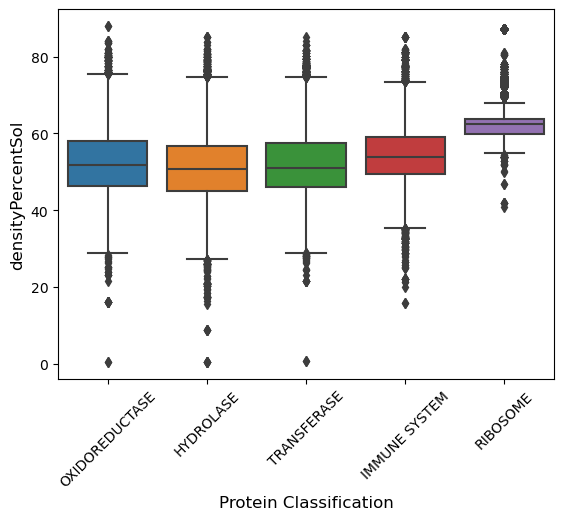

In [252]:
# densityPercentSol

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="densityPercentSol")
plt.ylabel("densityPercentSol", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


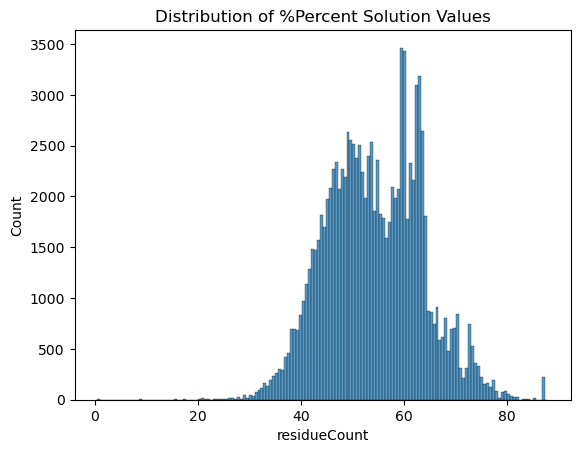

In [254]:
# distribution of densityPercentSol

plt.figure()
sns.histplot(mol_class_df_cleaned['densityPercentSol'])
plt.title('Distribution of %Percent Solution Values')
plt.xlabel('residueCount')
plt.ylabel('Count')
plt.show()

#### pH

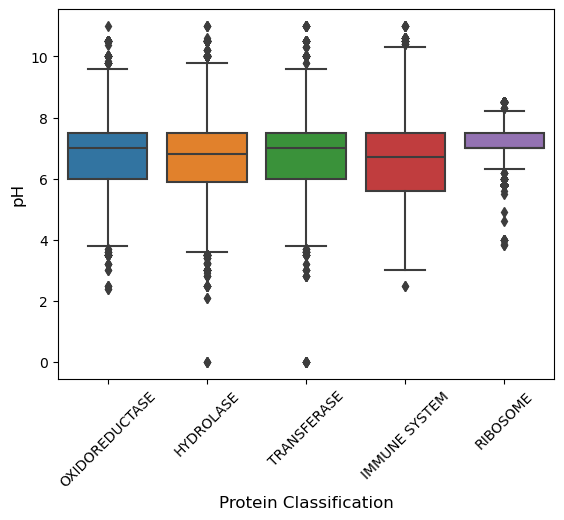

In [257]:
# phValue

plt.figure()
sns.boxplot(data=mol_class_df_cleaned, x="classification", y="phValue")
plt.ylabel("pH", fontsize=12)
plt.xlabel("Protein Classification", fontsize=12)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


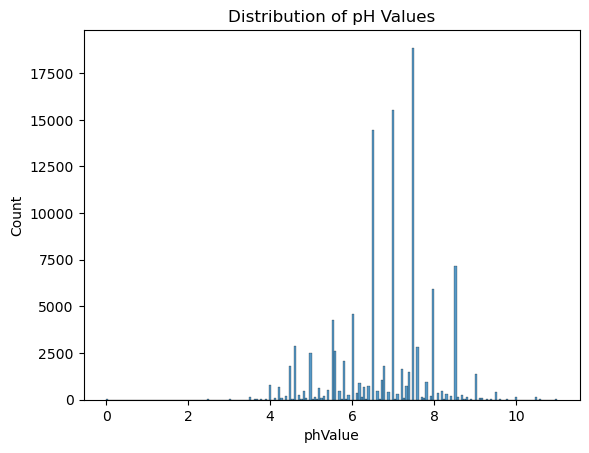

In [259]:
# distribution of phValue

plt.figure()
sns.histplot(mol_class_df_cleaned['phValue'])
plt.title('Distribution of pH Values')
plt.xlabel('phValue')
plt.ylabel('Count')
plt.show()

### Correlation Matrix

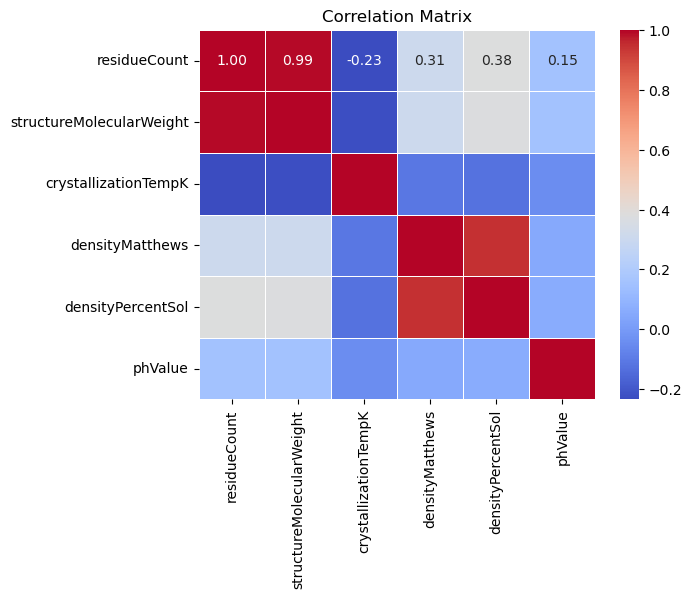

In [266]:
# isolate the numeric columns
numeric_cols = [
    'residueCount',
    'structureMolecularWeight',
    'crystallizationTempK',
    'densityMatthews',
    'densityPercentSol',
    'phValue'
]
df_nums = mol_class_df_cleaned[numeric_cols]
plt.figure()

# Generate the heatmap
sns.heatmap(df_nums.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Drop residueCount

The correlation between between residueCount and structureMolecularWeight is very strong, which is reasonable. However, with such a strong correlation it should not be necessary to include both features. Thus, we will drop residueCount.

In [ ]:
# drop residueCount
mol_class_df_cleaned = mol_class_df_cleaned.drop('residueCount', axis=1)

### Split the Data into Train and Test Sets

In [174]:
# train/test split

X = mol_class_df_cleaned.drop('classification', axis=1)
y = mol_class_df_cleaned['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape)
print(X_test.shape)

(81102, 5)
(27034, 5)


## Model Training

### Logistic Regression

In [184]:
logr = LogisticRegression(max_iter=1000)
logr_t0 = process_time()
logr.fit(X_train, y_train)
logr_t1 = process_time()

logr_fit_time = logr_t1 - logr_t0
print(f"LogisticRegression fit time: {logr_fit_time:0.2f} sec")

y_train_pred_logr = logr.predict(X_train)
acc_logr_train = accuracy_score(y_train, y_train_pred_logr)
print(f"LogisticRegression train accurancy: {acc_logr_train:0.2f}")

y_test_pred_logr = logr.predict(X_test)
acc_logr_test = accuracy_score(y_test, y_test_pred_logr)
print(f"LogisticRegression accuracy: {acc_logr_test:0.2f}")

LogisticRegression fit time: 12.19 sec
LogisticRegression train accurancy: 0.43
LogisticRegression accuracy: 0.43


#### Optimization of Logistic Regression Using GridSearchCV

In [301]:
grid_params = {'max_iter': [1000,5000,10000,20000,50000]}

logr_grid = GridSearchCV(logr, grid_params)
logr_grid.fit(X_train, y_train)

y_train_pred_logr_grid = logr_grid.predict(X_train)
acc_logr_grid_train = accuracy_score(y_train, y_train_pred_logr_grid)
print(f"LogisticRegression grid train accuracy: {acc_logr_grid_train:0.2f} (previous: {acc_logr_train:0.2f})")

y_test_pred_logr_grid = logr_grid.predict(X_test)
acc_logr_grid_test = accuracy_score(y_test, y_test_pred_logr_grid)
print(f"LogisticRegression grid test accuracy: {acc_logr_grid_test:0.2f} (previous: {acc_logr_test:0.2f})")

logr_best_params = logr_grid.best_params_
print(f"LogisticRegression best params: {logr_best_params}")

LogisticRegression grid train accuracy: 0.43 (previous: 0.43)
LogisticRegression grid test accuracy: 0.43 (previous: 0.43)
LogisticRegression best params: {'max_iter': 1000}


### KNN

In [188]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_t0 = process_time()
knn.fit(X_train, y_train)
knn_t1 = process_time()

knn_fit_time = knn_t1 - knn_t0
print(f"KNN fit time: {knn_fit_time:0.2f} sec")

y_train_pred_knn = knn.predict(X_train)
acc_knn_train = accuracy_score(y_train, y_train_pred_knn)
print(f"KNN train accuracy: {acc_knn_train:0.2f}")

y_test_pred_knn = knn.predict(X_test)
acc_knn_test = accuracy_score(y_test, y_test_pred_knn)
print(f"KNN test accuracy: {acc_knn_test:0.2f}")

KNN fit time: 0.11 sec
KNN train accuracy: 0.85
KNN test accuracy: 0.75


### Optimization of KNN Using GridSearchCV

In [193]:
grid_params = {'n_neighbors': np.arange(1,25,1) }

knn_grid = GridSearchCV(knn, grid_params, cv=10)
knn_grid.fit(X_train, y_train)

y_train_pred_knn_grid = knn_grid.predict(X_train)
acc_knn_grid_train = accuracy_score(y_train, y_train_pred_knn_grid)
print(f"KNN grid train accuracy: {acc_knn_grid_train:0.2f} (previous: {acc_knn_train:0.2f})")

y_test_pred_knn_grid = knn_grid.predict(X_test)
acc_knn_grid_test = accuracy_score(y_test, y_test_pred_knn_grid)
print(f"KNN grid test accuracy: {acc_knn_grid_test:0.2f} (previous: {acc_knn_test:0.2f})")

knn_best_params = knn_grid.best_params_
print(f"KNN best params: {knn_best_params}")

KNN grid train accuracy: 1.00 (previous: 0.85)
KNN grid test accuracy: 0.90 (previous: 0.75)
KNN best params: {'n_neighbors': 1}


this is an encouraging result at first glance, but with n=1 this appears to be overfit

### Decision Tree Classifier

In [195]:
dtc_model = DecisionTreeClassifier(max_depth=10)
dtc_t0 = process_time()
dtc_model.fit(X_train, y_train)
dtc_t1 = process_time()

dtc_fit_time = dtc_t1 - dtc_t0
print(f"DecisionTreeClassifier fit time: {dtc_fit_time:0.2f} sec")

y_train_pred_dtc = dtc_model.predict(X_train)
acc_dtc_train = accuracy_score(y_train, y_train_pred_dtc)
print(f"DecisionTreeClassifier train accuracy: {acc_dtc_train:0.2f}")

y_test_pred_dtc = dtc_model.predict(X_test)
acc_dtc_test = accuracy_score(y_test, y_test_pred_dtc)
print(f"DecisionTreeClassifier test accuracy: {acc_dtc_test:0.2f}")

#print(dtc_model.feature_importances_)

DecisionTreeClassifier fit time: 0.18 sec
DecisionTreeClassifier train accuracy: 0.58
DecisionTreeClassifier test accuracy: 0.57


### Optimization of the DecisionTreeClassifier Using GridSearchCV

In [199]:
dtc_grid_search_params = {
    'max_depth': [i for i in range(1,11)],
    'min_samples_split': [2,5,10],
    'max_features': [1,2,3,4,5,6]
}
dtc_grid = GridSearchCV(dtc_model, param_grid=dtc_grid_search_params)
dtc_grid.fit(X_train, y_train)

y_train_pred_dtc_grid = dtc_grid.predict(X_train)
acc_dtc_grid_train = accuracy_score(y_train, y_train_pred_dtc_grid)
print(f"DecisionTreeClassifier grid accuracy train: {acc_dtc_grid_train:0.2f} (previous: {acc_dtc_grid_train:0.2f})")

y_test_pred_dtc_grid = dtc_grid.predict(X_test)
acc_dtc_grid_test = accuracy_score(y_test, y_test_pred_dtc_grid)
print(f"DecisionTreeClassifier grid accuracy test: {acc_dtc_grid_test:0.2f} (previous: {acc_dtc_grid_test:0.2f})")

dtc_best_params = dtc_grid.best_params_
print(f"DecisionTreeClassifier best params: {dtc_best_params}")

DecisionTreeClassifier grid accuracy train: 0.61 (previous: 0.61)
DecisionTreeClassifier grid accuracy test: 0.59 (previous: 0.59)
DecisionTreeClassifier best params: {'max_depth': 10, 'max_features': 4, 'min_samples_split': 5}


### Support Vector Machine (SVM)

In [269]:
svc_model = SVC()
svc_t0 = process_time()
svc_model.fit(X_train, y_train)
svc_t1 = process_time()

svc_fit_time = svc_t1 - svc_t0
print(f"SVM fit time: {svc_fit_time:0.2f} sec")

y_train_pred_svc = svc_model.predict(X_train)
acc_svc_train = accuracy_score(y_train, y_train_pred_svc)
print(f"SVM train accuracy: {acc_svc_train:0.2f}")

y_test_pred_svc = svc_model.predict(X_test)
acc_svc_test = accuracy_score(y_test, y_test_pred_svc)
print(f"SVM test accuracy: {acc_svc_test:0.2f}")

SVM fit time: 92.51 sec
SVM train accuracy: 0.46
SVM test accuracy: 0.46


### Optimize SVM Using GridSearchCV

In [271]:
svc_grid_search_params = {
    'C': [0.1,0.5,1.0]
}
svc_grid = GridSearchCV(svc_model, param_grid=svc_grid_search_params)
svc_grid.fit(X_train, y_train)

svc_grid_best_c = svc_grid.best_params_['C']

y_train_pred_svc_grid = svc_grid.predict(X_train)
acc_svc_grid_train = accuracy_score(y_train, y_train_pred_svc_grid)
print(f"SVM grid train accuracy: {acc_svc_grid_train:0.2f} (previous: {acc_svc_train:0.2f})")

y_test_pred_svc_grid = svc_grid.predict(X_test)
acc_svc_grid_test = accuracy_score(y_test, y_test_pred_svc_grid)
print(f"SVM grid test accuracy: {acc_svc_grid_test:0.2f} (previous: {acc_svc_test:0.2f})")

svc_best_params = svc_grid.best_params_
print(f"SVM best params: {svc_best_params}")

SVM grid train accuracy: 0.46 (previous: 0.46)
SVM grid test accuracy: 0.46 (previous: 0.46)
SVM best params: {'C': 1.0}


### Random Forest Classifier

In [274]:
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_t0 = process_time()
rfc_model.fit(X_train, y_train)
rfc_t1 = process_time()

rfc_fit_time = rfc_t1 - rfc_t0
print(f"RandomForestClassifier fit time: {rfc_fit_time:0.2f} sec")

y_train_pred_rfc = rfc_model.predict(X_train)
acc_rfc_train = accuracy_score(y_train, y_train_pred_rfc)
print(f"RandomForestClassifier train accuracy: {acc_rfc_train:0.2f}")

y_test_pred_rfc = rfc_model.predict(X_test)
acc_rfc_test = accuracy_score(y_test, y_test_pred_rfc)
print(f"RandomForestClassifier test accuracy: {acc_rfc_test:0.2f}")

RandomForestClassifier fit time: 7.15 sec
RandomForestClassifier train accuracy: 1.00
RandomForestClassifier test accuracy: 0.94


### Optimize RandomForestClassifier Using GridSearchCV

In [293]:
rfc_grid_search_params = {
    'n_estimators': [100,200,500,1000]
}
rfc_grid = GridSearchCV(rfc_model, param_grid=rfc_grid_search_params)
rfc_grid.fit(X_train, y_train)

rfc_grid_best_n = rfc_grid.best_params_['n_estimators']

y_train_pred_rfc_grid = rfc_grid.predict(X_train)
acc_rfc_grid_train = accuracy_score(y_train, y_train_pred_rfc_grid)
print(f"RandomForestClassifier grid train accuracy: {acc_rfc_grid_train:0.2f} (previous: {acc_rfc_train:0.2f})")

y_test_pred_rfc_grid = rfc_grid.predict(X_test)
acc_rfc_grid_test = accuracy_score(y_test, y_test_pred_rfc_grid)
print(f"RandomForestClassifier grid test accuracy: {acc_rfc_grid_test:0.2f} (previous: {acc_rfc_test:0.2f})")

rfc_best_params = rfc_grid.best_params_
print(f"RandomForestClassifier best params: {rfc_best_params}")

RandomForestClassifier grid train accuracy: 1.00 (previous: 1.00)
RandomForestClassifier grid test accuracy: 0.94 (previous: 0.94)
RandomForestClassifier best params: {'n_estimators': 1000}


### Collect the Results

In [303]:
results = pd.DataFrame({
    'Model': ['LogisticRegression', 'KNN', 'DecisionTreeClassifier', 'SVM','RandomForestClassifier'],
    'Train Time (secs)': [logr_fit_time, knn_fit_time, dtc_fit_time, svc_fit_time, rfc_fit_time],
    'Train Accuracy': [acc_logr_grid_train, acc_knn_grid_train, acc_dtc_grid_train, acc_svc_grid_train, acc_rfc_grid_train],
    'Test Accuracy': [acc_logr_grid_test, acc_knn_grid_test, acc_dtc_grid_test, acc_svc_grid_test, acc_rfc_grid_test]
}).set_index('Model')
pd.options.display.float_format = '{:0.2f}'.format
print(results)

                        Train Time (secs)  Train Accuracy  Test Accuracy
Model                                                                   
LogisticRegression                  12.19            0.43           0.43
KNN                                  0.11            1.00           0.90
DecisionTreeClassifier               0.18            0.61           0.59
SVM                                 92.51            0.46           0.46
RandomForestClassifier               7.15            1.00           0.94


#### Confusion Matrix for the Decision Tree Classifier Model

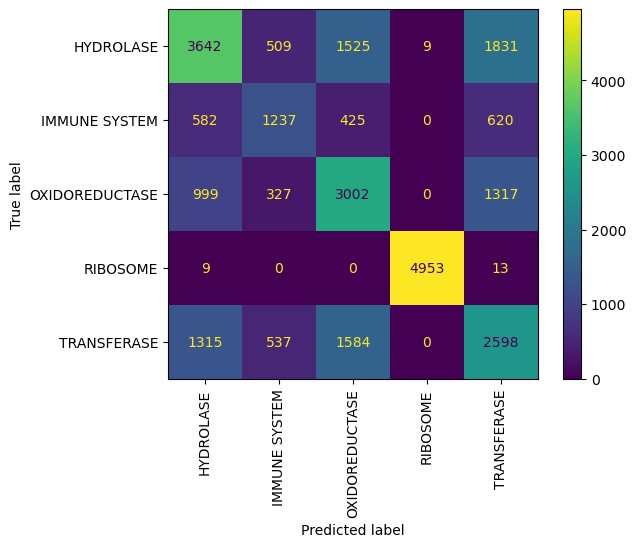

In [289]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred_dtc), display_labels=dtc_grid.classes_)
disp.plot(xticks_rotation="vertical")
plt.show()

#### Confusion Matrix for the Optimized KNN Model

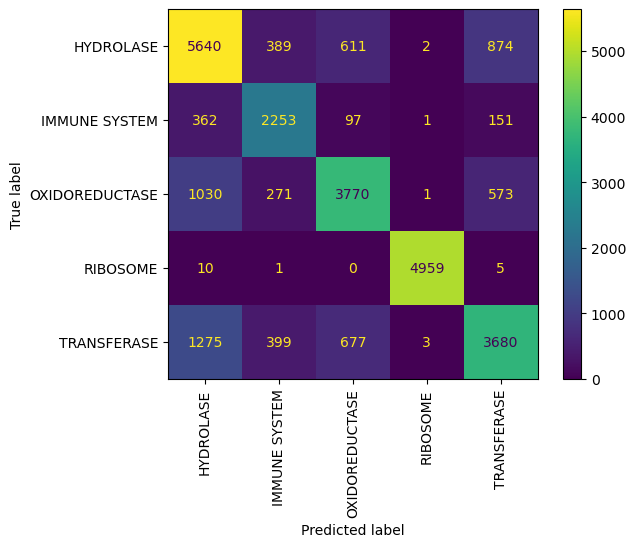

In [283]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred_knn), display_labels=knn_grid.classes_)
disp.plot(xticks_rotation="vertical")
plt.show()

#### Confusion Matrix for the Optimized RandomForestClassifier Model

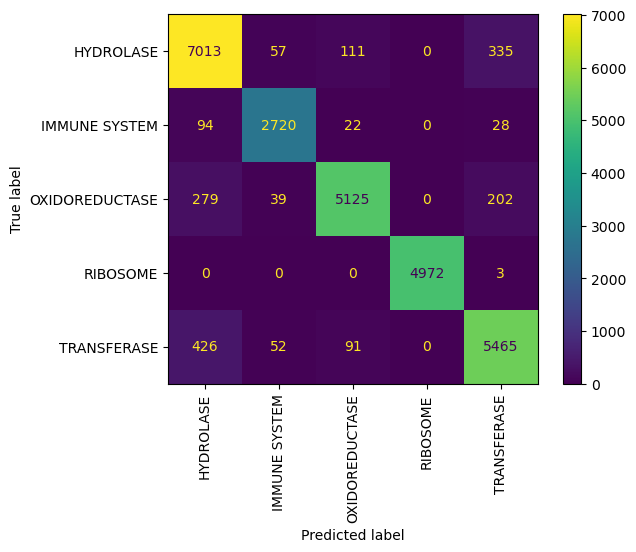

In [286]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred_rfc), display_labels=rfc_grid.classes_)
disp.plot(xticks_rotation="vertical")
plt.show()

## Comparing the Models

At first glance, it appeared that the KNN and Random Forest Classifiers showed the highest accuracy. However, with a training accuracy of 1.0 it seems clear that both of these models suffer from over-fitting even after running them through a grid search pattern, so for now those models have to be eliminated.

Among the remaining models, the Decision Tree Classifier appeared to perform the best on this particular problem with an overall accuracy of approximately 60%, whereas the Logistic Regression and Support Vector Machines had significantly lower accuracies.

## Conclusion and Recommendations
With an accuracy rate of around 60% we would call this result "encouraging". It does appear that machine learning can help us to identify the class of a protein based on superficial features. With additional features the performance could likely be improved significantly. This may also be a problem that a neural network might be able to perform well on, so that would be another suggestion for future improvements.